In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df= pd.read_csv('Stationarity_3.csv')

In [3]:
df.head(10)

,Date,Original,Value
0,2012-12-31,37.066559,0.000000
1,2013-01-01,37.417144,0.350585
2,2013-01-02,37.228052,-0.189092
3,2013-01-03,37.167616,-0.060436
4,2013-01-04,38.210898,1.043283
5,2013-01-05,37.965584,-0.245314
6,2013-01-06,38.183127,0.217543
7,2013-01-07,37.864936,-0.318192
8,2013-01-08,37.491172,-0.373764
9,2013-01-09,37.189294,-0.301878


In [4]:
df.shape

(3653, 3)

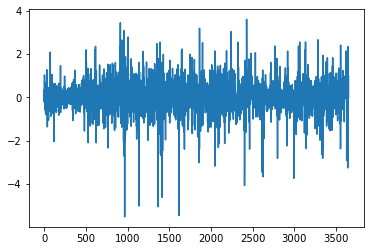

In [5]:
plt.plot(df['Value'])
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['value']=scaler.fit_transform(df[['Value']])

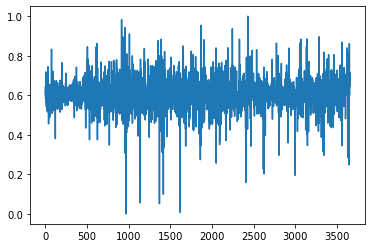

In [7]:
plt.plot(df['value'])
plt.show()

In [8]:
r_d=scaler.inverse_transform(np.array(df['value']).reshape(-1,1))

r_d

array([[ 0.        ],
       [ 0.350585  ],
       [-0.189092  ],
       ...,
       [ 1.03749862],
       [ 0.86875075],
       [ 0.        ]])

In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.python.keras.layers import LSTM

In [10]:
# let us build this function

def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

In [11]:
# now do the same for our original data & 6 day lag

d=df['value'].tolist()

steps=6 
x,y=split_sequence(d,steps)

In [12]:
#reshape 2d data to 3d to fit in cnn
features=1
x=x.reshape((x.shape[0],x.shape[1],features))

print(x.shape)

(3647, 6, 1)


In [13]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [14]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
# fit model

model.fit(x,y,epochs=2000,verbose=0)

In [16]:
t_i1=array([0.304381189024771,0.301713307515281,0.301576848232958,0.290095456717525,0.295064792801103,0.289618173982269])
t_i1=t_i1.reshape(1,steps,features)
y_p1=model.predict(t_i1,verbose=0)
print(y_p1)

[[0.76662356]]


In [17]:
test_data_x= x[-300:]
test_data_y= y[-300:]

In [18]:
test_data_pred=model.predict(test_data_x)

10/10 [==============================] - 0s 6ms/step


In [19]:
test_data_pred.shape

(300, 1)

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean = np.mean(test_data_pred)
abs_deviations = np.abs(test_data_pred-mean)
mad = np.mean(abs_deviations)
print("MAD:", mad)

mse = mean_squared_error(test_data_y,test_data_pred)
rmse = np.sqrt(mse)
print("RMSE :",rmse)


def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
print("MAPE:", mape)


def mean_bias_error(y_actual, y_predicted):
    return mean_squared_error(y_actual,y_predicted)

mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
print("MSE:", mbe)

MAD: 0.052252788
RMSE : 0.013560174821195753
MAPE: 14.17579810112026
MSE: 0.00018387834118139128


In [21]:
from sklearn.metrics import r2_score

r2_score(test_data_y,test_data_pred)

0.971340604150877

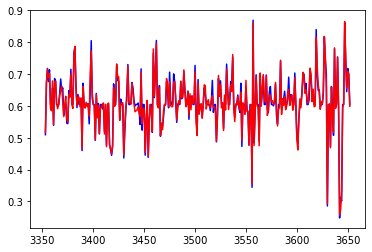

In [22]:
plt.plot(df.tail(300).index, test_data_y, color='blue')
plt.plot(df.tail(300).index, test_data_pred, color='red')
plt.show()

In [23]:
#function to increase date by 1

from datetime import datetime, timedelta

def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")
    return formatted_date 

start_date='2022-12-31'
increase(start_date)

'2023-01-01'

In [24]:
# forecasting 50 days future data

data=df['value'].tolist()
forecasted_df=pd.DataFrame(columns=['date','value'])
start_date='2022-12-31'

for i in range(50):
    new_date=increase(start_date)
    forecast_input=array(data[-6:])
    x_forecast=forecast_input.reshape(1,steps,features)
    forecasted_y=model.predict(x_forecast).item()
    #print(np.array(forecasted_y))
    #x=np.concatenate((x,np.array(x_forecast)))
    #y=np.concatenate((y,np.array([forecasted_y])))
    #model.fit(x,y,epochs=5,verbose=0)
    forecasted_df.at[i,'date']=new_date
    forecasted_df.at[i,'value']=forecasted_y
    data.append(forecasted_y)
    start_date=new_date

1/1 [==============================] - 0s 40ms/step


In [25]:
forecasted_df

,date,value
0,2023-01-01,0.483604
1,2023-01-02,0.494073
2,2023-01-03,0.486198
3,2023-01-04,0.62983
4,2023-01-05,0.601362
5,2023-01-06,0.686851
6,2023-01-07,0.716038
7,2023-01-08,0.700199
8,2023-01-09,0.652687
9,2023-01-10,0.675105


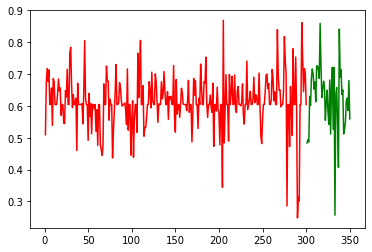

In [26]:
index_old=np.arange(1,301)
index_new=np.arange(301,351)

plt.plot(index_old, test_data_y, color='red')
plt.plot(index_new,forecasted_df['value'], color='green')

In [27]:
forcasted_dif=scaler.inverse_transform(np.array(forecasted_df['value']).reshape(-1,1))

In [28]:
dif_list=np.array(forcasted_dif).flatten().tolist()

dif_list

[-1.1050724797452764,
 -1.0091745357999358,
 -1.0813082585529017,
 0.23433131919047206,
 -0.02643087515415281,
 0.7566266105452772,
 1.023973143520638,
 0.8788954858647879,
 0.44369254097557037,
 0.6490332760544714,
 0.07836930208666593,
 1.1126930118318494,
 1.1099413479264673,
 0.9945964015053805,
 0.7506897864764032,
 2.3314710172979383,
 1.0899950604028101,
 0.1990412296039459,
 0.44571807135036556,
 0.6712289396277663,
 0.5131163661502894,
 -0.4551908863633278,
 0.05347493321886628,
 0.4142994200084951,
 -0.20890932332077652,
 -0.5763263382170501,
 0.705325549591839,
 -0.8528292512235942,
 0.45287348943448036,
 1.072704346933871,
 -0.7152389584086987,
 1.0689219009940918,
 -3.1829969375452176,
 0.30584509861713616,
 0.48883620797565547,
 -0.580383404582307,
 -1.8098167371534335,
 2.1709687547502514,
 0.7941486052995023,
 1.00257731876111,
 0.28652394108785656,
 0.41679775612576275,
 -0.8479139277830872,
 -0.7138887868138555,
 -0.4988997571841779,
 0.10355412436670035,
 0.181358513

In [29]:
last_value=df.tail(1)['Original'].iloc[0]

last_value

#print(last_value+dif_list[1])

79.299999375

In [30]:
forecasted_og=[]

for i in range(len(dif_list)):
    n=last_value+dif_list[i]
    forecasted_og.append(n)
    last_value=n
    
forecasted_df['Retrive']=forecasted_og

In [31]:
forecasted_df

,date,value,Retrive
0,2023-01-01,0.483604,78.194927
1,2023-01-02,0.494073,77.185752
2,2023-01-03,0.486198,76.104444
3,2023-01-04,0.62983,76.338775
4,2023-01-05,0.601362,76.312345
5,2023-01-06,0.686851,77.068971
6,2023-01-07,0.716038,78.092944
7,2023-01-08,0.700199,78.971840
8,2023-01-09,0.652687,79.415532
9,2023-01-10,0.675105,80.064566


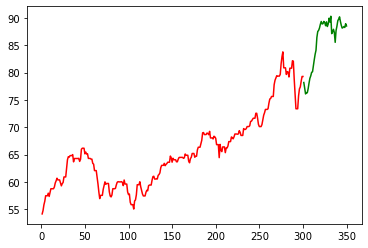

In [32]:
index_old=np.arange(1,301)
index_new=np.arange(301,351)

last_300 = df['Original'][-300:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,forecasted_df['Retrive'], color='green')